# Detection on One Image 
This file shows an example to detect players and football in image.

In [1]:
%load_ext autoreload
%autoreload 2

### Object detection
Perform object detection on the test image by YOLO3

First, we import the [YOLO model](https://arxiv.org/abs/1506.02640) (this is a `Keras` implementation of [YOLOv3](https://pjreddie.com/media/files/papers/YOLOv3.pdf) from [github](https://github.com/experiencor/keras-yolo3)) and the pre-trained weights. The YOLO3 is trained on the [MSCOCO dataset](http://cocodataset.org/#home).
Then we save the model for further use.

In [2]:
from test import yolo_model

Using TensorFlow backend.


set the model input image size, threshold value for objectness `obj_thresh` and non-max suppression `nms_thresh`.

In [3]:
input_h, input_w = 416, 416
obj_thresh, nms_thresh = 0.5, 0.45

make the predefined yolo model

In [4]:
model = yolo_model.make_yolov3_model()

load pretrained model weights from [https://pjreddie.com/media/files/yolov3.weights](https://pjreddie.com/media/files/yolov3.weights) and save in the `test` folder.

In [6]:
weight_path = 'test/yolov3.weights'
weight_reader = yolo_model.WeightReader(weight_path) # load the model weights
weight_reader.load_weights(model)  # set the model weights into the model

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

Then we read in a test image.

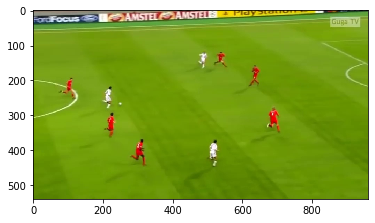

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_file = 'resources/frame0.jpg'
orig_image = cv2.imread(image_file)

plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))

Before feeding the image into the model, the image needs to be preprocessed. More specifically, the image needs to be resized to match the input size of the model. Besides, one tiny issue is that `cv2` reads in image in a BGR order, so the color channels of the image needs to be reordered.

In [8]:
orig_h, orig_w = orig_image.shape[0:2]
image = yolo_model.preprocess_input(orig_image, input_h, input_w)

Now, we are ready to make a prediction.

In [9]:
y_pred = model.predict(image)

`y_pred` is a list of predictions by the YOLO model, and each list element corresponds to a yolo prediction at one scale. In fact, yolo3 gives prediction at 3 scales so that it can capture both small and large objects. Corresponding to each scale, there are three sizes of anchor boxes predefined in the `yolo_model.anchors`. In general, anchor box means a pre-defined shape used in the YOLO model to detect different objects.

**Decode the prediction**

To obtain the object information for the original image, we need to do a few three steps:
1. decode `y_pred` into bounding box
2. remove the boxes with a objectness score lower than `obj_thresh`
3. perform non-max suppression to remove the extra boxes for the same object
4. transform the box size back to the correct size in the original image

In [10]:
boxes = []
for i, y in enumerate(y_pred):
    # decode the output of the network
    boxes += yolo_model.decode_netout(y[0], yolo_model.anchors[i], obj_thresh, nms_thresh, input_h, input_w)

# non-maximal suppression
yolo_model.do_nms(boxes, nms_thresh)

# correct the sizes of the bounding boxes
yolo_model.correct_yolo_boxes(boxes, orig_h, orig_w, input_h, input_w)

Now, we can draw the boxes on the original image and save it as a new image.

In [11]:
# draw bounding boxes on the image using labels
detected_image = yolo_model.draw_boxes(orig_image, boxes, yolo_model.labels, obj_thresh) 

# write the image with bounding boxes to file
detected_image_file = 'test/frame0_detected.jpg'
cv2.imwrite(detected_image_file, detected_image.astype('uint8'))

person: 94.79771256446838%
person: 93.16078424453735%
person: 99.06469583511353%
person: 92.7547812461853%
person: 96.929931640625%
sports ball: 59.49851870536804%
person: 99.64313507080078%
person: 97.9532539844513%
person: 99.60941672325134%
person: 98.59451651573181%


True

#### Display image

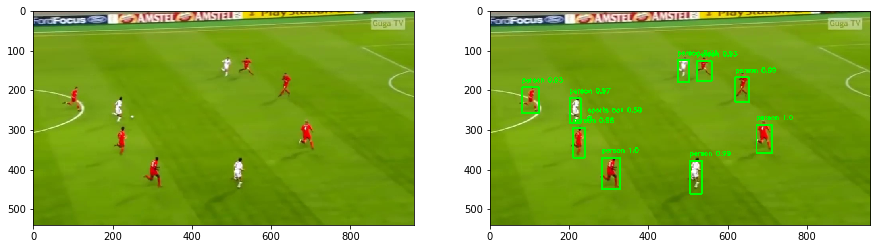

In [12]:
fig = plt.figure(figsize=(15,8))
fig.add_subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))

another way to display image using IPython.display in original size

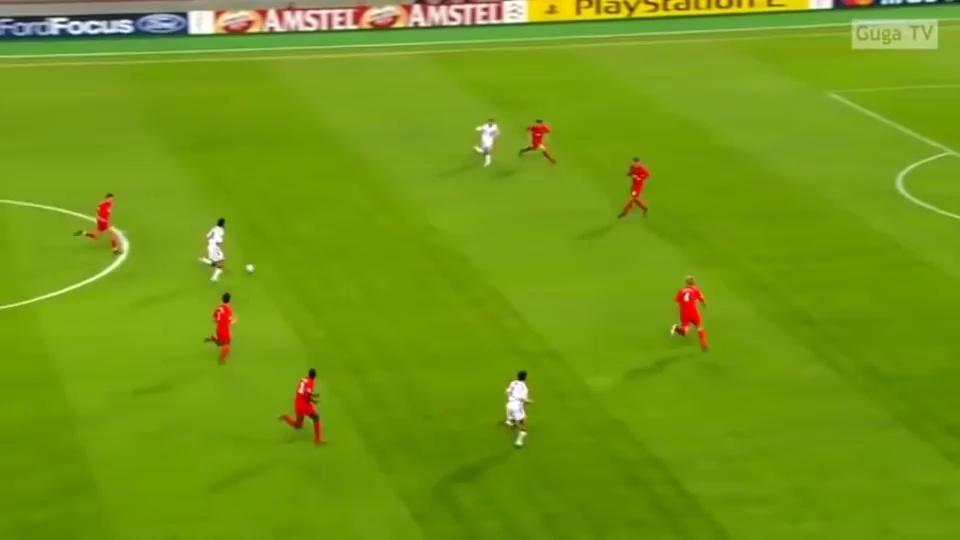

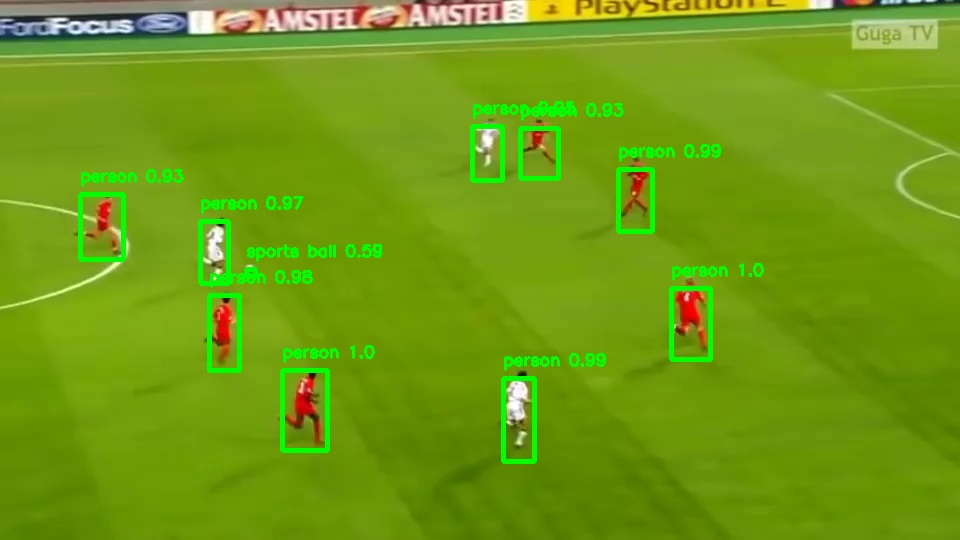

In [13]:
from IPython.display import Image, display
x, y = Image(image_file), Image(detected_image_file)
display(x, y)

* The prediction for players are generally very good with all the probabilities above 0.9, but because of the small size, the probability for football is relatively low, slightly higher than the `obj_thresh`. So it is important to give different thresholds for the player and the ball.

#### Wrap up the workflow
We can wrap up all the steps above into one working function `one_image_detection`.

In [14]:
orig_image = cv2.imread('resources/frame65.jpg')
detected_image = yolo_model.one_image_detection(orig_image = orig_image, 
                                                model = model,
                                                model_input_shape = (input_h, input_w),
                                                obj_thresh = obj_thresh, 
                                                nms_thresh = nms_thresh)

person: 96.65499925613403%
person: 96.58596515655518%
person: 99.28674101829529%
person: 96.38326168060303%
person: 99.04139041900635%
person: 99.47150945663452%
person: 99.62069392204285%
person: 98.24633598327637%


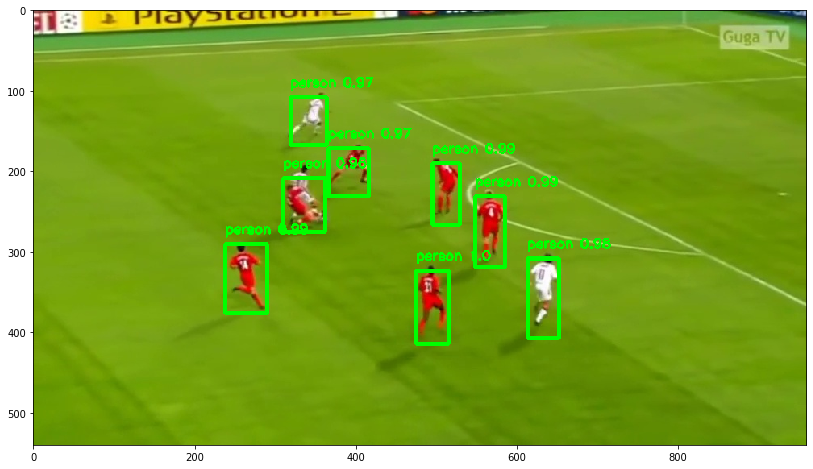

In [15]:
fig = plt.figure(figsize=(15,8))
fig.add_subplot(1, 1, 1)
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))

This example shows something more interesting. Because two player are almost overlapped in the same area (Gerrard(red) slide tackling Kaka(white)), the model only detects one object. Further, the football is missed because it can hardly be seen in this picture.

However, this type of model error is expected because in YOLO model, a non-maximal suppression algorithm is used to get rid of objects that has a large overlapping area. More specifically, the Intersection over Union (IoU) is measured, and the boxes that has an IoU larger than the `nms_thresh` with the box of maximal probability will be removed.